In [7]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import os
import re

#Source code page: http://astro.uni-tuebingen.de/software/idl/aitlib/astro/binarycor.html
#Source code link: http://astro.uni-tuebingen.de/software/idl/aitlib/astro/binarycor.pro

In [14]:
def Binary_orbit(time,asini,porb,ecc,omega_d,t0=-1,t90=-1,pporb=0.0,limit=1.0*10**-10,maxiter=40):

	time=np.array(time)  #time should be an array to prevent round-off errors
	if t90==-1 and t0==-1:
		print("error: need t90 or t0 value")
		return

	if t90!=-1 and t0!=-1:
		print("error: Only one of the t90 and t0 arguments is allowed")
		return

	if ecc<0 :
		print("error: eccentricity must be positive!")
		return
	if ecc>=1:
		print("error: Orbit correction has only been implemented for circular and elliptic orbits")
		return
	if ecc==0:
		omega_d=0 #circular orbit
	print(t0)
	if t0 ==-1:
		t0 = t90+(omega_d-90.)/360. * porb
		print(t0,"Debugging time")
		
	if maxiter <=0:
		maxiter=20

	asini_d = asini/86400. #86400 seconds in a day, unit is light day
	t= time

	#Corrections for eccentricity 0<=ecc<1
	omega = omega_d * np.pi/180.0 # Radians conversion
	sinw = np.sin(omega)
	cosw = np.cos(omega)
	sq = ((1.-ecc)*(1.+ecc))**0.5
	cor =np.array([2.*limit]*len(t))
	

	#start with number of iterations = zero
	numiter=0
			
	contada=0
	print('starting iterations (max 20)')
	while((abs(np.amax(cor)) > limit) and (numiter < maxiter)):
		tper = (t-t0)/porb
		print(tper)
		# Calculate the mean anomaly
		m = 2 * np.pi * (tper * (1. - 0.5 * pporb * tper))
		print(m)
		# Normalize m to the range [0, 2π]
		m = m % (2 * np.pi)

		# Shift m to the range [-π, π] if needed
		m[m > np.pi] -= 2 * np.pi
		print(m)
		m=np.array(m)

		print("Mean Anomaly:" ,m)
		
		eanom=np.array([1.0]*len(t))
		eanom = KeplerEquation1(m,ecc)  #use this command for a better solution
		
		print("Eccentric Anomaly:", eanom)  # Debugging line

		sin_e = np.sin(eanom)
		cos_e = np.cos(eanom)
		print("e: ",ecc,"a_sin_i",asini_d,"omega ",omega)
		print("sinE: ",sin_e)
		print("cosE: ",cos_e)
		z = asini_d*(sinw*(cos_e-ecc)+sq*cosw*sin_e) ##Romer Delay Term
		#print("correction factor(z): ",z*86400)
		f = (t-time)+z  
		print("term f: ",f)                             
		df = (sq*cosw*cos_e - sinw*sin_e)*(2*np.pi*asini_d/(porb*(1.0-ecc*cos_e)))
		print("term df:",df)
		cor =f/(1.0+df)
		print("Final Correction: ",cor)
		t = t-cor #### Altering it to add this time 
		numiter=numiter+1
		contada=contada+1
		print('iteration ' + str(contada)+' completed (max 20)')
		if numiter >= maxiter:
			print("Exceeded maxiter iterations and did not reach convergence");
			break
	return(t)


In [15]:
def KeplerEquation1(m,ecc):
	m=np.array(m)
	if ecc<0 :
		print("error: eccentricity must be positive!")
		return
	if ecc>=1:
		print("error: Orbit correction has only been implemented for circular and elliptic orbits")
	
	#print("Mean anomaly input to kepler:", m)
	for j in range(0,len(m)):
		mod_m=m[j]/2/np.pi
		m[j]=m[j]-2*np.pi*round(mod_m)
		
		while m[j]>np.pi:
			m[j]=m[j]-2*np.pi
		while m[j]<-np.pi:
			m[j]=m[j]+2*np.pi
	if ecc==0:
		E=m
		
	aux=4.0*ecc+0.5
	alpha=(1.0-ecc)/aux
	
	Beta=m/(2.0*aux)
	aux=np.sqrt(Beta**2+alpha**3)
	
	z=Beta+aux
	test=np.array([1.0]*len(z))
	for j in range(0,len(m)):
		if z[j]<=0.0:
			z[j]=Beta[j]-aux[j]
			
		test[j]=abs(z[j])**(1/3)
	z=test
	for j in range(0,len(m)):
		if z[j]<0.0:
			z[j]=-z[j]
	s0=z-alpha/z
	
	s1=s0-(0.078*s0**5)/(1.0+ecc)
	e0=m+ecc*(3.0*s1-4.0*s1**3)	
	
	se0=np.sin(e0)
	ce0=np.cos(e0)
	
	##Newton Raphson method
	f  = e0-ecc*se0-m
	f1 = 1.0-ecc*ce0
	f2 = ecc*se0
	f3 = ecc*ce0
	f4 = -f2
	u1 = -f/f1
	u2 = -f/(f1+0.50*f2*u1)
	u3 = -f/(f1+0.50*f2*u2+.16666666666667*f3*u2*u2)
	u4 = -f/(f1+0.50*f2*u3+.16666666666667*f3*u3*u3+.041666666666667*f4*u3**3)
	
	eccanom=e0+u4
	
	for j in range(0,len(m)):
		while eccanom[j]>=2.0*np.pi:
			eccanom[j]=eccanom[j]-2.0*np.pi
		while eccanom[j]<2.0*np.pi:
			eccanom[j]=eccanom[j]+2.0*np.pi
	##better solution
	#print("ecc anomaly before iteration inside kepler equation :", eccanom)

	CONT=True
	thresh=10**-3
	for j in range(0,len(m)):
		if m[j]<0:
			m[j]=m[j]+2.0*np.pi
	diff=eccanom-np.sin(eccanom)-m
	for j in range(0,len(m)):
		if abs(diff[j])>10**-10:
			I=diff[j]
			while CONT==True:
				fe=eccanom[j]-ecc*np.sin(eccanom[j])-m[j]
				fs=1.0-ecc*np.cos(eccanom[j])
				oldval=eccanom[j]
				eccanom[j]=oldval-fe/fs
				if abs(oldval-eccanom[j])<thresh :CONT=False
			while eccanom[j]>= np.pi:eccanom[j]=eccanom[j]-2.0*np.pi
			while eccanom[j]< np.pi:eccanom[j]=eccanom[j]+2.0*np.pi

	# Iterate until convergence for each m value
	thresh = 1e-6  # Convergence threshold
	for j in range(len(m)):
        # Iterative correction (Newton-Raphson method)
		max_iter = 40  # Maximum number of iterations for each eccentric anomaly
		iter_count = 0
		
		while iter_count < max_iter:
            # Calculate the difference (Kepler's equation)
			fe = eccanom[j] - ecc * np.sin(eccanom[j]) - m[j]
			fs = 1.0 - ecc * np.cos(eccanom[j])

			# If fs is too small, break out to avoid division by zero
			if abs(fs) < 1e-10:
				break

			# Update the Eccentric Anomaly using Newton-Raphson
			new_eccanom = eccanom[j] - fe / fs

			# Check for convergence
			if abs(new_eccanom - eccanom[j]) < thresh:
				eccanom[j] = new_eccanom
				break
			eccanom[j] = new_eccanom
			iter_count += 1

        # If maximum iterations are exceeded, print a warning
		if iter_count >= max_iter:
			print(f"Warning: Did not converge for m[{j}] after {max_iter} iterations.")

		# Ensure the final value is within [-pi, pi]
		while eccanom[j] >= np.pi:
			eccanom[j] -= 2 * np.pi
		while eccanom[j] < -np.pi:
			eccanom[j] += 2 * np.pi
	return eccanom


In [17]:
## Function to find event files/lc files from the directory 
def find_event_files(base_directory):
    event_files = []
    
    # Regular expression to match the pattern ObsID/xti/event_cl/
    obsid_pattern = re.compile(r'^\d{10}$')
    #obsid_pattern = re.compile(r'^\d{10}/xti/event_cl/$')
    #For one file
    #obsid_pattern = re.compile(r'6050390244/xti/event_cl/$')
    
    # Regular expressions to match the specific filename patterns
    file_pattern = re.compile(r'^ni\d{10}_0mpu7_cl_(night|daynotconsidered)_barycorr.evt$')
    #file_pattern = re.compile(r'^ni\d{10}_cl_(night|day)mpu7_sr_night_barycorr.lc$')


    for obsid_dir in os.listdir(base_directory):
        obsid_path = os.path.join(base_directory, obsid_dir)

        # Check if it's a directory and matches the 10-digit ObsID pattern
        if os.path.isdir(obsid_path) and obsid_pattern.match(obsid_dir):
            #print(f"Found 10-digit ObsID folder: {obsid_dir}")

            # Look for files in this directory matching the .evt pattern
            for file in os.listdir(obsid_path):
                if file_pattern.match(file):
                    full_path = os.path.join(obsid_path, file)
                    event_files.append(full_path)
                    # print(f"Found .evt file: {full_path}")

    return event_files

In [18]:
# Method to write corrected FITS file
def write_corrected_fits(original_fits, corrected_timestamps):
    base_name = os.path.basename(original_fits)
    original_dir = os.path.dirname(original_fits)
    
    # Construct the new filename
    new_file = os.path.join(original_dir, base_name.replace('.evt', '_orbit_piexpiex.evt'))
    #new_file = os.path.join(original_dir, base_name.replace('.lc', '_orbit_piexpiex.lc'))

    try:
        # Read the original FITS file and modify the 'TIME' column
        with fits.open(original_fits, mode='readonly') as hdul:
            # Extract necessary values from the header
            MJDREFI = hdul[1].header['MJDREFI']
            MJDREFF = hdul[1].header['MJDREFF']
            TIMEZERO = hdul[1].header['TIMEZERO']

            # Combine MJDREFI and MJDREFF to get the full MJDREF
            MJDREF = MJDREFI + MJDREFF

            # Convert the MJD timestamps to MET using the formula
            corrected_met = (corrected_timestamps - MJDREF) * 86400 - TIMEZERO

            hdul[1].data['TIME'] = corrected_met
            hdul.writeto(new_file, overwrite=True)
        
        print(f"Corrected FITS file saved as {new_file}")
    
    except Exception as e:
        print(f"Error saving corrected FITS file: {str(e)}")

In [21]:
# Main function to process event files and save corrected fits files

def process_event_files(base_directory, asini, porb, ecc, omega_d, t0, t90):
    event_files = find_event_files(base_directory)
    
    all_input_times = []
    all_corrected_times = []

    for event_file in event_files:
        with fits.open(event_file) as evt:
            # Extract input times
            met = evt[1].data['BARYTIME'] ##Use this when evt while with Barytime=Yes is used. 
            #met = evt[1].data['TIME'] ## Use this on barycorr lc or evt files where Barytime=No
            # Check if BARYTIME is empty, skip if so
            if len(met) == 0:
                print(f"Skipping file {event_file}: No time values found.")
                continue
        
            #print(met)
            times = ((met+evt[1].header['TIMEZERO']) / 86400) + evt[1].header['MJDREFI'] + evt[1].header['MJDREFF']
            all_input_times.append(times)
            #print(times)
            # Correct the times using your Binary_orbit function
            corrected_times = Binary_orbit(times, asini, porb, ecc, omega_d, t0=t0,t90=t90)
            all_corrected_times.append(corrected_times)

            print("Romer Delay: ",(times-corrected_times))
            # Save the corrected FITS file
            write_corrected_fits(event_file, corrected_times)
    return all_input_times, all_corrected_times

In [22]:
############
# Input parameters taken from: 
# https://gammaray.nsstc.nasa.gov/gbm/science/pulsars/lightcurves/swiftj0243.html
############

base_directory = "./reduced_output" #Change the data accordingly\
asini = 115.531  # in light-seconds
porb = 27.6943  # in days
ecc = 0.1029
omega_d = -74.05
t0=-1
t90 = 58116.097  # Modified Julian Date

# Run the processing
input_times, corrected_times=process_event_files(base_directory, asini, porb, ecc, omega_d,t0=t0, t90=t90)

-1
58103.476861347226 Debugging time
starting iterations (max 20)
[74.76617255 74.76617255 74.76617255 ... 74.79443367 74.79443367
 74.79443367]
[469.76971685 469.76971685 469.76971686 ... 469.94728669 469.9472867
 469.9472867 ]
[-1.46918119 -1.46918118 -1.46918118 ... -1.29161134 -1.29161134
 -1.29161134]
Mean Anomaly: [-1.46918119 -1.46918118 -1.46918118 ... -1.29161134 -1.29161134
 -1.29161134]
Eccentric Anomaly: [-1.57208111 -1.5720811  -1.5720811  ... -1.39288716 -1.39288715
 -1.39288715]
e:  0.1029 a_sin_i 0.001337164351851852 omega  -1.292416311101801
sinE:  [-0.99999917 -0.99999917 -0.99999917 ... -0.98421586 -0.98421586
 -0.98421586]
cosE:  [-0.00128478 -0.00128477 -0.00128477 ...  0.17697213  0.17697214
  0.17697214]
term f:  [-0.00023155 -0.00023155 -0.00023155 ... -0.00045496 -0.00045496
 -0.00045496]
term df: [-0.00029176 -0.00029176 -0.00029176 ... -0.00027747 -0.00027747
 -0.00027747]
Final Correction:  [-0.00023162 -0.00023162 -0.00023162 ... -0.00045509 -0.00045509
 -0

In [28]:
input_times_flat = np.concatenate(input_times)
corrected_times_flat = np.concatenate(corrected_times)

In [9]:
np.savez("lc_corrected_time_piexpiex.npz", input_times=input_times_flat, corrected_times=corrected_times_flat)
print(f"Times saved successfully")

Times saved successfully


In [10]:
delays=(input_times_flat-corrected_times_flat)*86400.

In [11]:
delays

array([-20.01183322, -20.01183385, -20.01183385, ..., -39.31984117,
       -39.31984117, -39.3198418 ])

## Plotting all the delays

In [12]:
import numpy as np
import matplotlib.pyplot as plt
data=np.load("evt_corrected_time_piexpiex.npz")

In [13]:
input=np.sort(data['input_times'])
corrected=np.sort(data['corrected_times'])

In [14]:
input

array([60045.60321999, 60045.60322032, 60045.60322036, ...,
       60203.71351316, 60203.71351321, 60203.71351334])

In [15]:
delay= (corrected-input)*86400

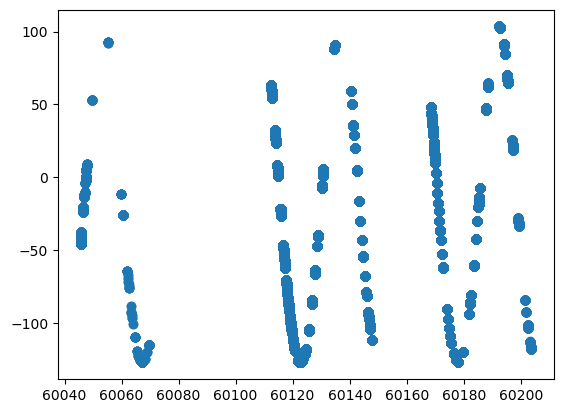

In [16]:
plt.scatter(input[::200],(delay)[::200])

In [17]:
# # Orbital parameters provided TEST
# a_sin_i = 115.531  # Semi-major axis in light-seconds
# P_orb = 27.6943  # Orbital period in days
# e = 0.1029  # Eccentricity
# omega = -74.05  # Longitude of periastron in degree
# T_pi2 = 58116.097  # T_pi/2 in seconds 

# evt=fits.open('./reduced_output/6050390248/ni6050390248_0mpu7_cl_night_barycorr_orbit.evt')
# met=evt[1].data['BARYTIME']
# times=(met/86400)+evt[1].header['MJDREFI'] +evt[1].header['MJDREFF']
# print(times)
#TIME=Binary_orbit(time=times,asini=a_sin_i,ecc=e,porb=P_orb,omega_d=omega,t90=T_pi2)